**Note: If you modify any external Python modules (ex. in the optlearn library), to load the changes, be sure to restart the kernel before the next run.**

***All of these code blocks are dependencies of future blocks unless otherwise noted.***

Config

In [ ]:
DATA_DIR = 'tsplib-data' # Relative to this notebook
# These directories are all relative to DATA_DIR
PROBLEMS_DIR = 'problems' # Input: problems
SOLUTIONS_DIR = 'solutions' # Input: precomputed solutions
NP_DIR = 'npy' # Output: features (and maybe labels)

# See the functions dict (line 478) in ./optlearn/optlearn/feature/features.py
# For any feature computation function named compute_fX_edges, you can add fX here
# DESIRED_EDGE_FEATURES = ['fg']
DESIRED_EDGE_FEATURES = ['fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fi', 'fj']

# Uses fg weights of 1/iteration (1-indexed) instead of iteration/k
USE_PAPER_FG = True

# Even if the features already exist, overwrite them
OVERRIDE_FEATURES = True
if OVERRIDE_FEATURES:
	print('Warning: Any feature weights already computed may be overwritten.')

# Builds the labels directory along with the features directories
BUILD_LABELS = True

# Choose the layout function for arranging nodes in the visualizations
# Recommended choices: nx.spiral_layout, nx.spring_layout
import networkx as nx
VIZ_LAYOUT = nx.spring_layout

Imports and Utility functions

In [60]:
import os
DATA_PATH = os.path.join(os.path.abspath(''), DATA_DIR)
PROBLEMS_PATH = os.path.join(DATA_PATH, PROBLEMS_DIR)
SOLUTIONS_PATH = os.path.join(DATA_PATH, SOLUTIONS_DIR)
NP_PATH = os.path.join(DATA_PATH, NP_DIR)

from optlearn.data.data_utils import dataLoader
loader = dataLoader([])

import numpy as np
np.set_printoptions(linewidth=np.inf)

Clear output directory to recompute everything from scratch (optional)
(doesn't work yet)

In [61]:
import shutil
if input('Proceed to clear all output data? (y/n) ').lower() == 'y':
	for filename in os.listdir(NP_PATH):
		file_path = os.path.join(NP_PATH, filename)
		if os.path.isfile(file_path) or os.path.islink(file_path):
			os.unlink(file_path)
		elif os.path.isdir(file_path):
			shutil.rmtree(file_path)
	print('Cleared')

Cleared


Plotting utilities (required for plots)

In [62]:
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

import matplotlib.pyplot as plt

PYPLOT_W, PYPLOT_H = 4, 4 # in inches
ARC_RADIUS = 0.15

class TSPPlotData:
	def __init__(self, G: nx.Graph | nx.DiGraph):
		self.G = G
		self.edges = get_edges(G)
		self.pos = VIZ_LAYOUT(G)
		self.weights = get_weights(G)
	
	def plot(self, edge_values_list, ax=None, use_alpha=False):
		nx.draw_networkx_nodes(self.G, self.pos, ax=ax)
		nx.draw_networkx_labels(self.G, self.pos, font_size=10, font_color='w', ax=ax)
		connectionstyle = 'arc3' + (f',rad={ARC_RADIUS}' if self.G.is_directed() else '')
		nx.draw_networkx_edges(
			self.G,
			self.pos,
			edge_color=('black' if use_alpha else 'grey'),
			ax=ax,
			alpha=(edge_values_list.clip(0, 1) if use_alpha else 1),
			connectionstyle=connectionstyle
		)
		if not use_alpha:
			edge_labels = {}
			for edge_idx, edge in enumerate(self.edges):
				edge_labels[edge] = round(edge_values_list[edge_idx], 3)
			nx.draw_networkx_edge_labels(
				self.G,
				self.pos,
				edge_labels,
				label_pos=(0.3 if self.G.is_directed() else 0.5),
				bbox={"alpha": 0},
				ax=ax,
				connectionstyle=connectionstyle
			)
plot_cache: dict[str, TSPPlotData] = {}

Load Problems (required for pretty-printing/plots)

In [63]:
for problem_file_name in os.listdir(PROBLEMS_PATH):
	print(f'Loading {problem_file_name}...')
	problem_name = problem_file_name.removesuffix('.tsp')
	problem_file_path = os.path.join(PROBLEMS_PATH, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	G = optObject().read_problem_from_file(problem_file_path).get_graph()
	plot_cache[problem_name] = TSPPlotData(G)

Loading ulysses16.tsp...


Plot problems (optional)

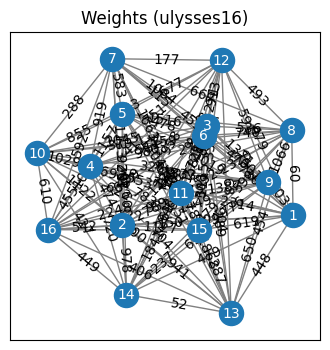

In [64]:
for problem_name, plot_data in plot_cache.items():
	plot_data.plot(plot_data.weights)
	plt.title(f'Weights ({problem_name})')
	plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
	plt.show()

Build features (and labels if enabled)

In [65]:
import optlearn.mst.mst_model
optlearn.mst.mst_model.use_paper_fg = USE_PAPER_FG

import optlearn.data.data_utils
optlearn.data.data_utils.build_labels = BUILD_LABELS

import numpy as np
np.set_printoptions(linewidth=np.inf)

from optlearn.experiments.build_data import build_features
build_features(
	NP_PATH,
	PROBLEMS_PATH,
	DESIRED_EDGE_FEATURES,
	override=OVERRIDE_FEATURES,
	solution_dir=SOLUTIONS_PATH
)


Status:
Directory Status: Checked/Built


Iteration 1 of 4
Iteration 2 of 4
Iteration 3 of 4
Iteration 4 of 4
Problem 1 of 1 completed

Status:
Directory Status: Checked/Built
Features Status: Checked/Built/Written
Current Problem: N/A


Done! :D


Load features (required for pretty-printing/plotting)

In [66]:
for problem_name, plot_data in plot_cache.items():
	plot_data.features_data = loader.load_features([
		os.path.join(NP_PATH, feature, problem_name + '.npy')
		for feature in DESIRED_EDGE_FEATURES])

Pretty-print features in a table (optional)

In [67]:
from tabulate import tabulate
for problem_name, plot_data in plot_cache.items():
	print(f'{problem_name}:')
	print(tabulate(
		plot_data.features_data,
		headers=DESIRED_EDGE_FEATURES,
		showindex=enumerate(plot_data.edges)
	))

ulysses16:
                        fa         fb         fc         fd         fe         ff        fg
---------------  ---------  ---------  ---------  ---------  ---------  ---------  --------
(0, (1, 2))      0.182796   0.220302   0.182796   0.103922   0.119608   0.24902    0.5
(1, (1, 3))      0.179928   0.216847   0.18395    0.105578   0.121514   0.252988   0.333333
(2, (1, 4))      0.112186   0.135205   0.122553   0.169329   0.194888   0.86901    0.5
(3, (1, 5))      0.365591   0.440605   0.667976   0.0519608  0.0598039  0.394118   0
(4, (1, 6))      0.264158   0.318359   0.465866   0.0719132  0.082768   0.157395   0
(5, (1, 7))      0.235484   0.283801   0.395307   0.0806697  0.0928463  0.17656    0
(6, (1, 8))      0.0218638  0.0263499  0.0262818  0.868852   1          1          1
(7, (1, 9))      0.37276    0.449244   0.717241   0.0509615  0.0586538  0.316346   0
(8, (1, 10))     0.260573   0.314039   0.428151   0.0729023  0.0839065  0.397524   0
(9, (1, 11))     0.829749   1

Plot features (optional)

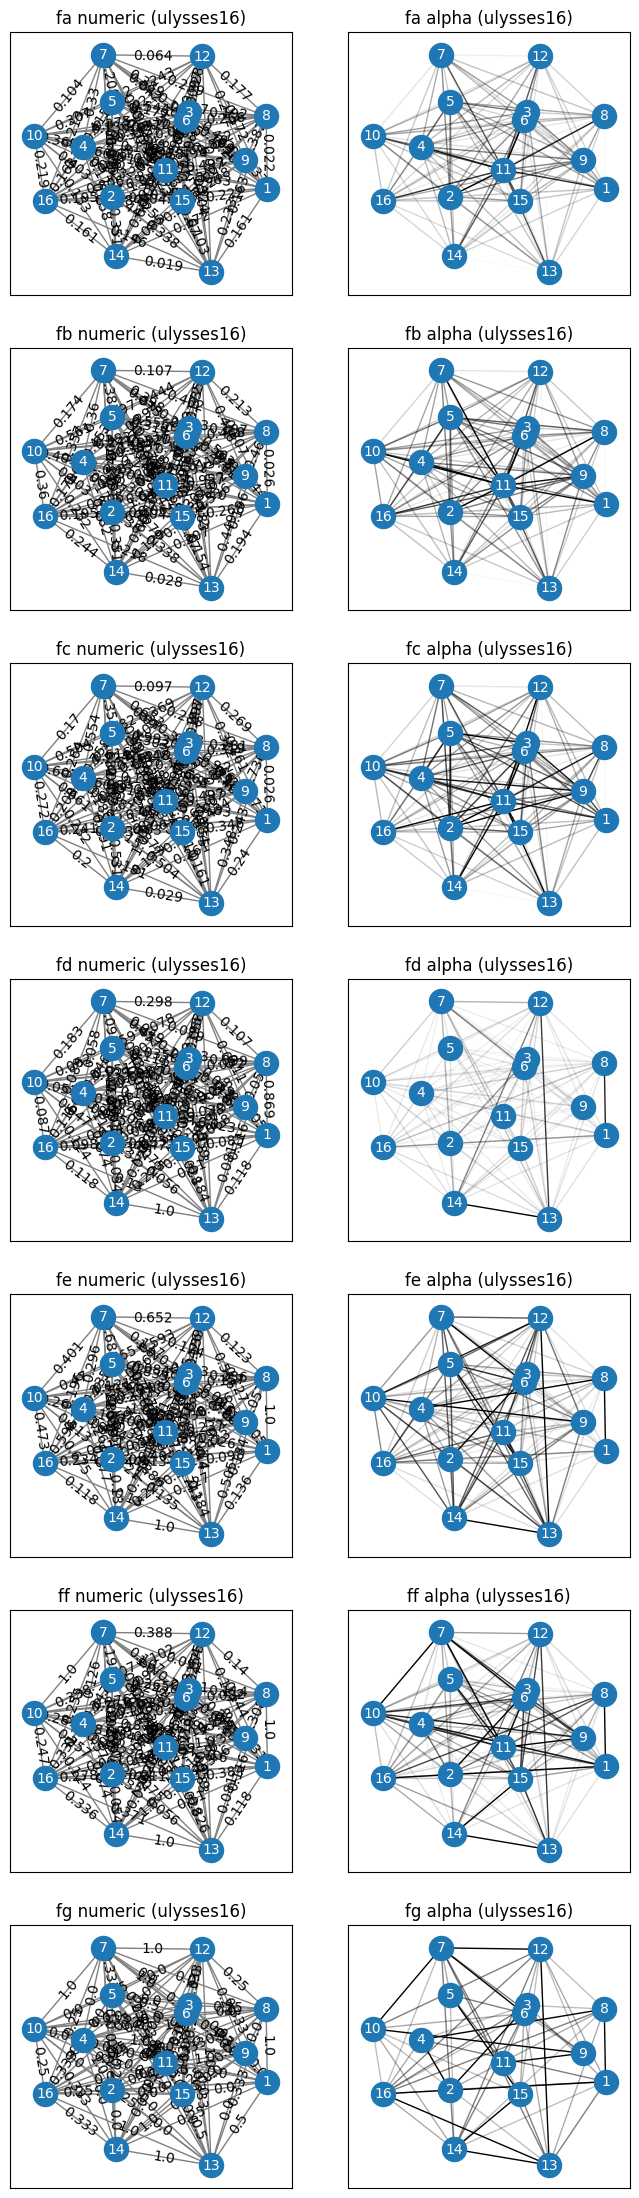

In [68]:
for problem_name, plot_data in plot_cache.items():
	# Based on
	# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
	fig, ax = plt.subplots(len(DESIRED_EDGE_FEATURES), 2)
	# Standardizes ax as a 2D list
	if len(DESIRED_EDGE_FEATURES) == 1:
		ax = [ax]

	for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
		ax_numeric: plt.Axes = ax[feature_idx][0]
		feature_data = plot_data.features_data[:,feature_idx]
		plot_data.plot(feature_data, ax=ax_numeric)
		ax_numeric.set_title(f'{feature} numeric ({problem_name})')

		ax_alpha: plt.Axes = ax[feature_idx][1]
		plot_data.plot(feature_data, ax=ax_alpha, use_alpha=True)
		ax_alpha.set_title(f'{feature} alpha ({problem_name})')
	
	fig.set_size_inches(PYPLOT_W * 2, PYPLOT_H * len(DESIRED_EDGE_FEATURES))
	plt.show()


Load and plot solutions (optional)

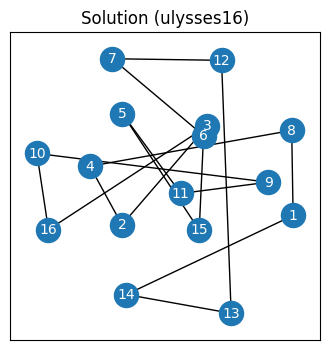

In [69]:
for problem_name, plot_data in plot_cache.items():
	plot_data.labels = loader.load_labels(
		os.path.join(NP_PATH, 'solutions', problem_name + '.npy'))
	plot_data.plot(plot_data.labels, use_alpha=True)
	plt.title(f'Solution ({problem_name})')
	plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
	plt.show()